In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.20 GB, difference +0.20 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
import decoupler as dc

In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [6]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [7]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [8]:
obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")
adata.obs = updated_obs


In [10]:
#subset adata

select_cell_type = "Mature Neutrophils"


select_control_sample = "KC"
select_condition_sample = "UL"


select_sample = [
    select_condition_sample,
    select_control_sample
]
sample_mask = adata.obs["sample"].isin(select_sample)



In [11]:
adata = adata[sample_mask].copy()

/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col = "sample_code",
    groups_col = "cell_type_sub_prolif_anno",
    layer = "counts",
    mode = "sum",
    min_cells = 10,
    min_counts = 1000
)
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

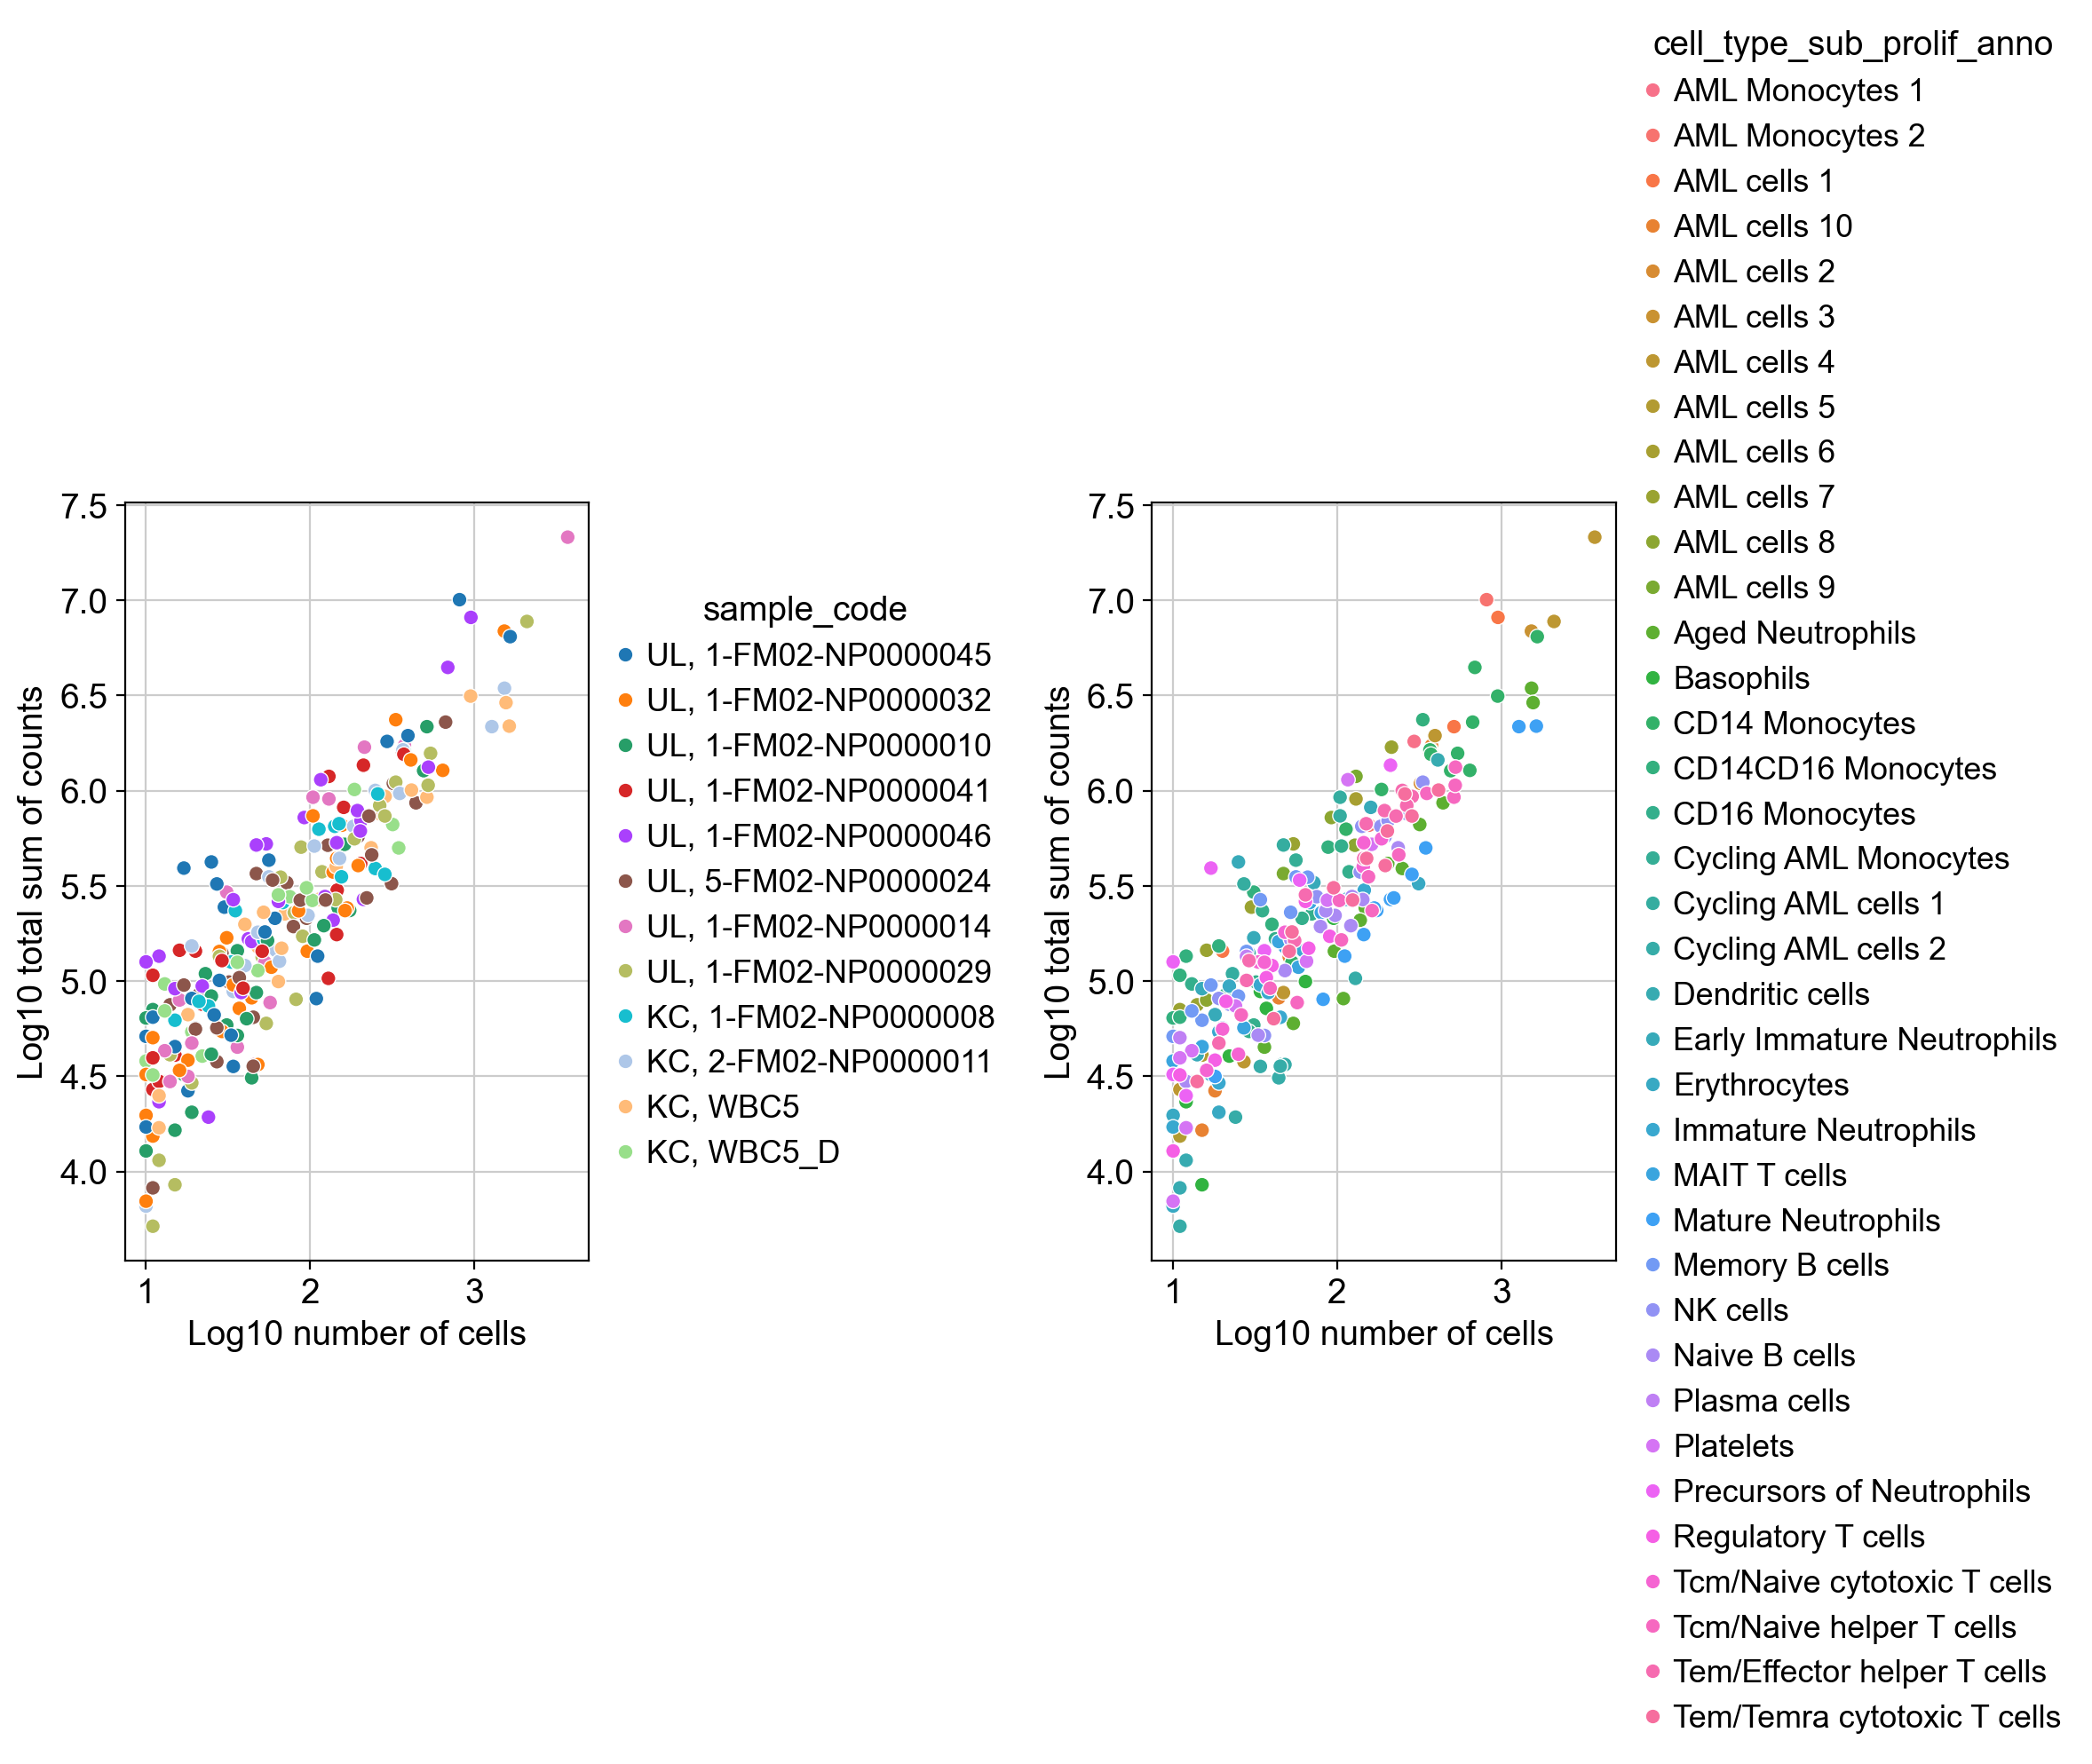

In [15]:
dc.plot_psbulk_samples(pdata, groupby=["sample_code", "cell_type_sub_prolif_anno"], figsize=(12, 9))

In [16]:
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

In [17]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum = 1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value = 10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [18]:
pdata

AnnData object with n_obs × n_vars = 258 × 31931
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [19]:
# Select Neutrophils profiles
print(select_cell_type)
neutrophils = pdata[pdata.obs["cell_type_sub_prolif_anno"] == select_cell_type].copy()

Mature Neutrophils


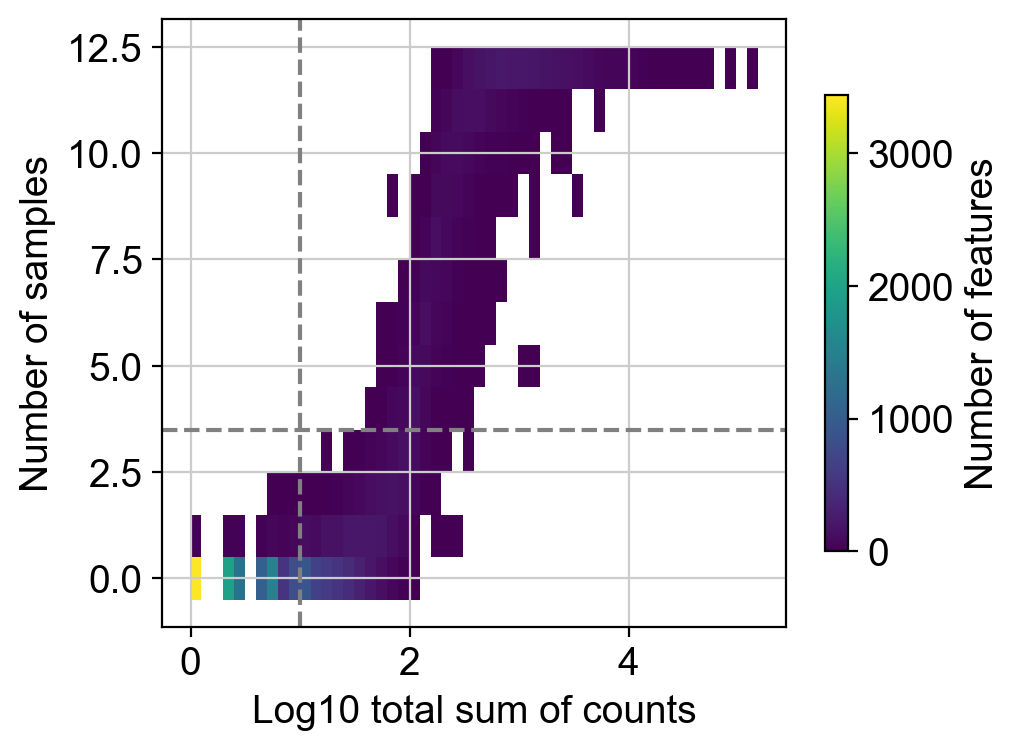

In [20]:
dc.plot_filter_by_expr(neutrophils, group = "sample", min_count = 5, min_total_count = 10)


In [21]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(neutrophils, group = "sample", min_count = 5, min_total_count = 10)

# Filter by these genes
neutrophils = neutrophils[:, genes].copy()
neutrophils


AnnData object with n_obs × n_vars = 12 × 5222
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [22]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [23]:
neutrophils.obs["sample"].unique()

array(['KC', 'UL'], dtype=object)

In [24]:
# Build DESeq2 object
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    adata = neutrophils,
    design_factors = "sample",
    ref_level = ["sample", select_control_sample],
    refit_cooks = True,
    inference = inference,
)

In [25]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.54 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.54 seconds.

Fitting LFCs...
... done in 0.48 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 16 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [26]:
# Extract contrast between AML vs HD
stat_res = DeseqStats(
    dds,
    contrast=["sample", select_condition_sample, select_control_sample],
    inference = inference,
)

In [27]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: sample UL vs KC
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A3GALT2   6.623392       -0.260725  0.601848 -0.433208  0.664864  0.861038
AAGAB     7.738493        1.113786  0.469919  2.370164  0.017780  0.119936
AAK1     44.729801        1.114110  0.233908  4.763030  0.000002  0.000203
AATF     26.709308       -0.420284  0.381827 -1.100719  0.271019  0.588241
AATK     48.258880       -0.643077  0.368220 -1.746450  0.080733  0.305933
...            ...             ...       ...       ...       ...       ...
ZSWIM8   10.129613       -0.384068  0.420168 -0.914082  0.360674  0.666318
ZXDC     35.450185        0.488873  0.317979  1.537439  0.124186  0.386167
ZYG11B   18.370848       -0.678207  0.364529 -1.860501  0.062815  0.262155
ZYX      76.377074       -0.231807  0.350433 -0.661488  0.508300  0.770912
ZZEF1    43.716940       -0.088473  0.230039 -0.384602  0.700532  0.880472

[5222 rows x 6 columns]


... done in 0.17 seconds.



In [28]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A3GALT2,6.623392,-0.260725,0.601848,-0.433208,0.664864,0.861038
AAGAB,7.738493,1.113786,0.469919,2.370164,0.017780,0.119936
AAK1,44.729801,1.114110,0.233908,4.763030,0.000002,0.000203
AATF,26.709308,-0.420284,0.381827,-1.100719,0.271019,0.588241
AATK,48.258880,-0.643077,0.368220,-1.746450,0.080733,0.305933
...,...,...,...,...,...,...
ZSWIM8,10.129613,-0.384068,0.420168,-0.914082,0.360674,0.666318
ZXDC,35.450185,0.488873,0.317979,1.537439,0.124186,0.386167
ZYG11B,18.370848,-0.678207,0.364529,-1.860501,0.062815,0.262155
ZYX,76.377074,-0.231807,0.350433,-0.661488,0.508300,0.770912


In [29]:
# Export volcano genes
results_df.to_csv("dge/pseudobulk_volcano_mature_neutrophils_AML_vs_HD.csv")

results_df_sorted = results_df.copy()
results_df_sorted[results_df_sorted["padj"] < 0.05].sort_values(by = "log2FoldChange", ascending=False, key=abs).to_excel("dge/pseudobulk_volcano_mature_neutrophils_AML_vs_HD_filtered_by_padj.xlsx")


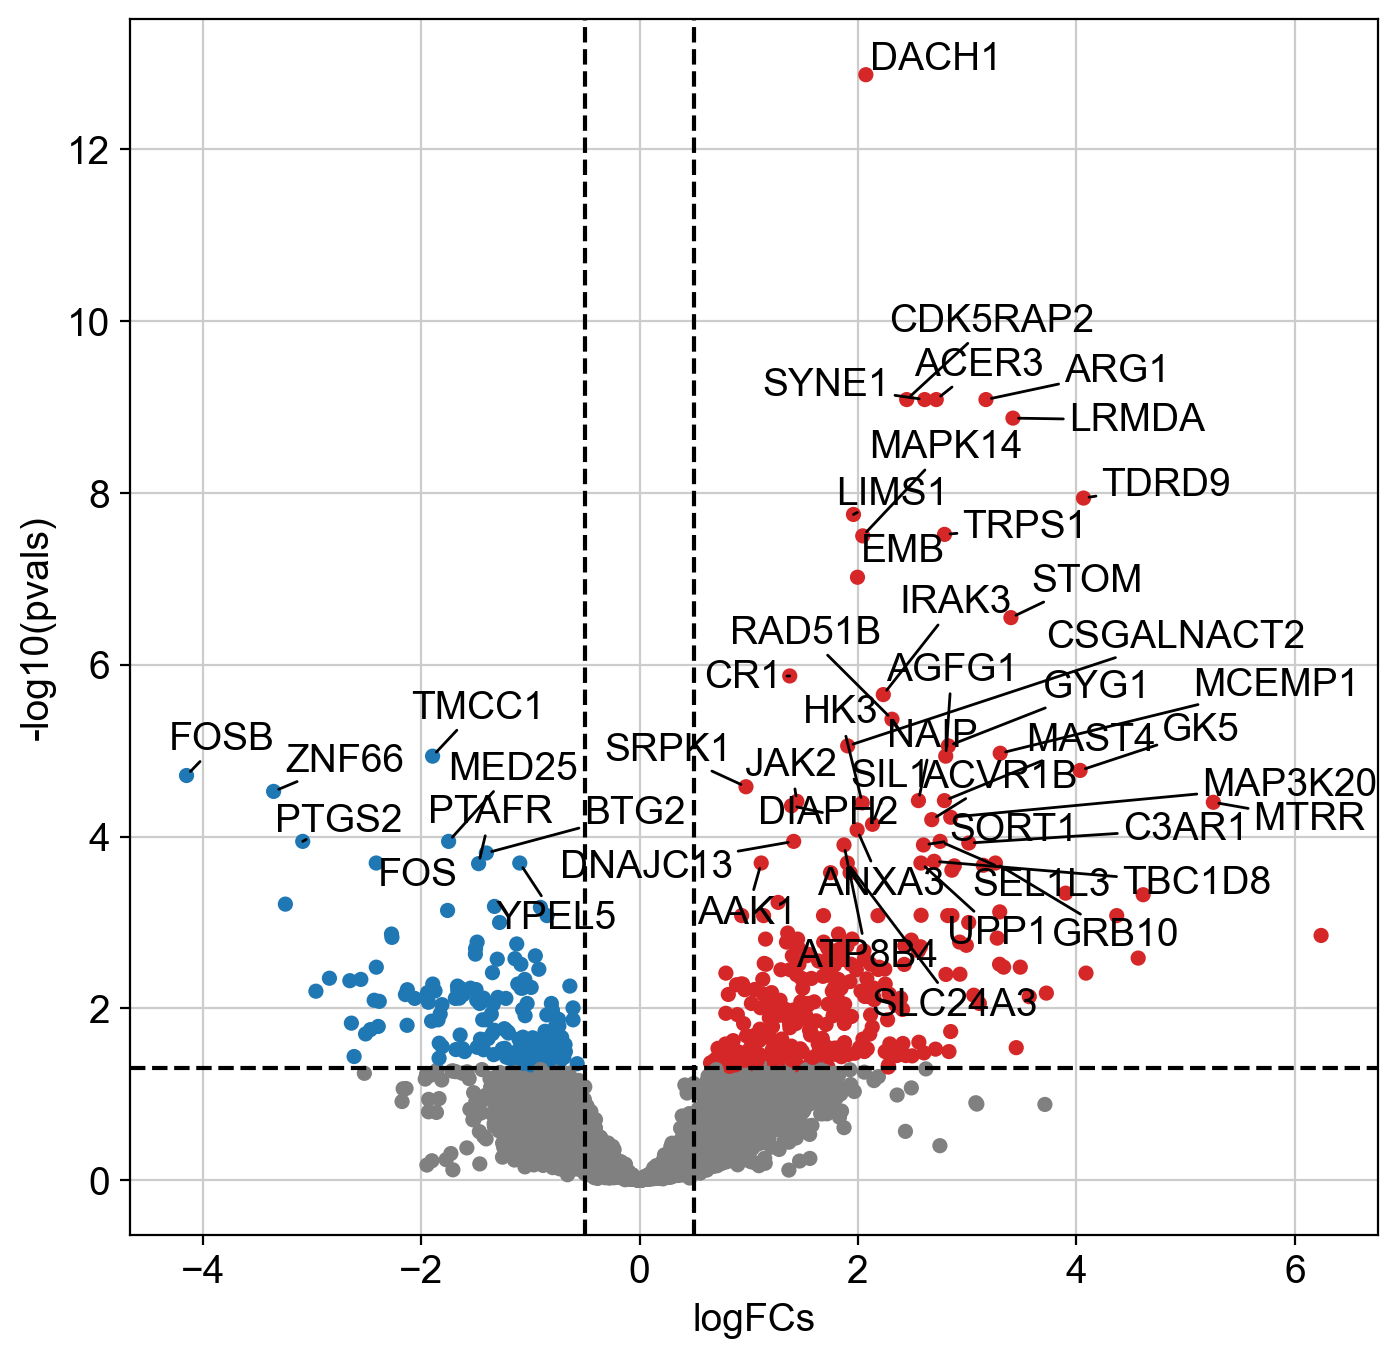

In [31]:
fig = dc.plot_volcano_df(
    results_df,
    x = "log2FoldChange",
    y = "padj",
    top = 50,
    figsize = (8, 8), return_fig = True
)


In [12]:
select_cell_type = "Mature Neutrophils"
print(select_cell_type)
mat = results_df[["stat"]].T.rename(index={"stat": select_cell_type})
mat

Mature Neutrophils


,A3GALT2,AAGAB,AAK1,AATF,AATK,ABAT,ABCA1,ABCA2,ABCA5,ABCA7,...,ZNRF2,ZRANB1,ZRANB2,ZRSR2,ZSWIM6,ZSWIM8,ZXDC,ZYG11B,ZYX,ZZEF1
Mature Neutrophils,-0.433208,2.370164,4.76303,-1.100719,-1.74645,-2.111838,1.04403,1.312882,1.118324,-1.793821,...,1.38527,-0.950749,1.307587,1.608224,-0.843318,-0.914082,1.537439,-1.860501,-0.661488,-0.384602


# ORA

In [14]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [18]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]

# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]

# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]

msigdb_filtered

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


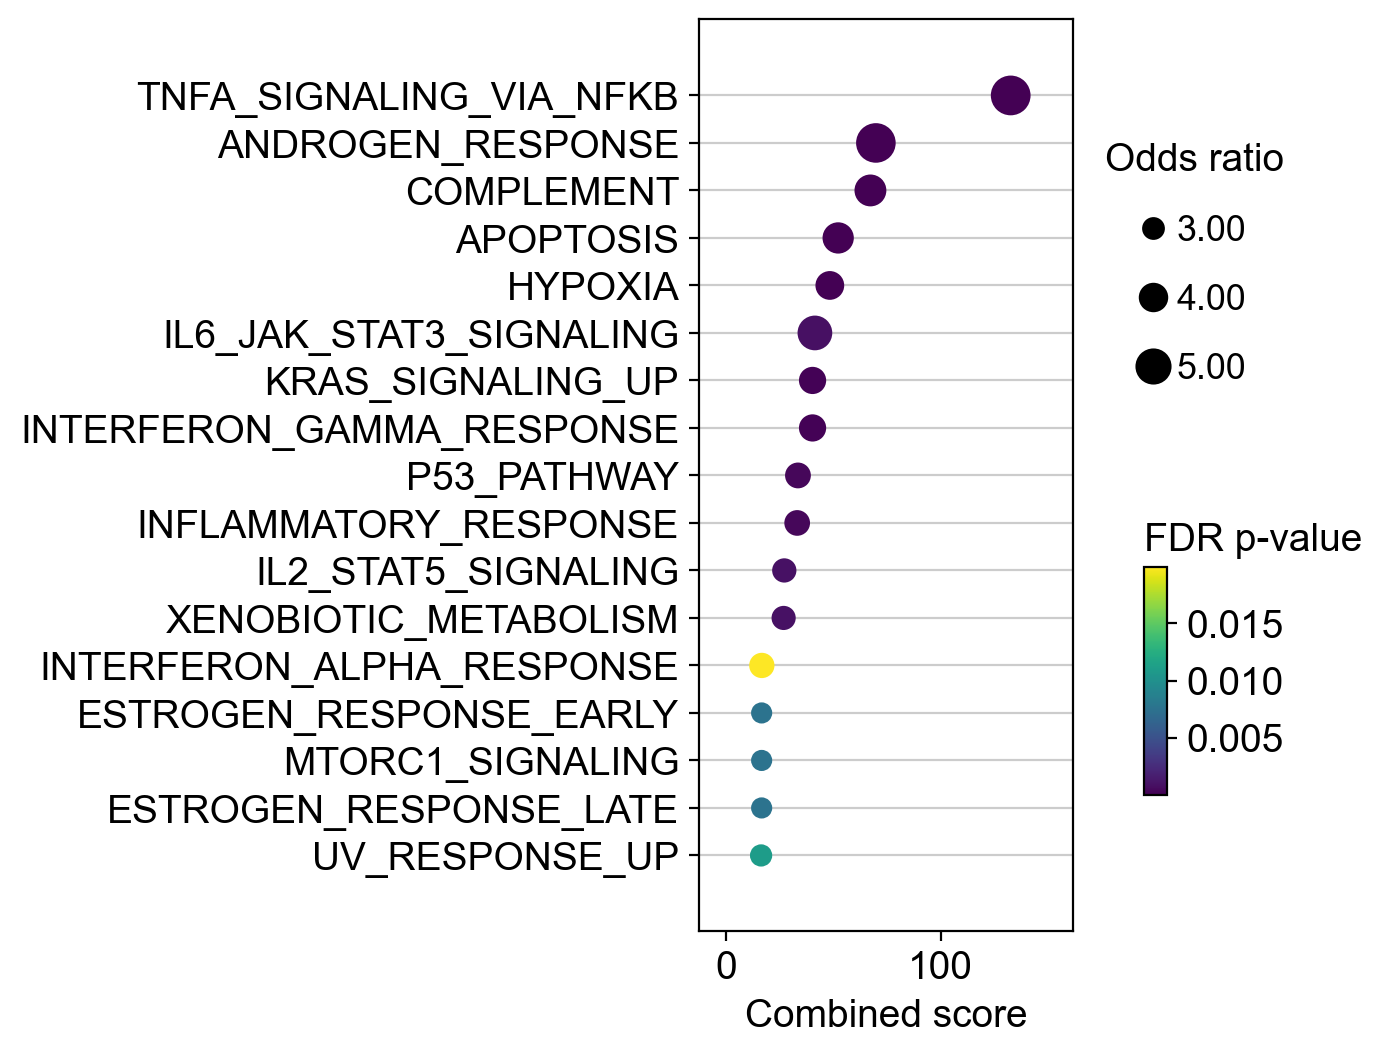

In [37]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]
# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]
# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]
msigdb_filtered

try:
    
    # Infer enrichment with ora using significant deg
    top_genes = results_df[(results_df["padj"] < 0.05)]

    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df = top_genes,
        net = msigdb_filtered,
        source = "geneset",
        target = "genesymbol"
    )
    
    enr_pvals_select = enr_pvals[(enr_pvals["FDR p-value"] < 0.05)].sort_values("Combined score", ascending=False)
    
    dc.plot_dotplot(
        enr_pvals_select,
        x = "Combined score",
        y = "Term",
        s = "Odds ratio",
        c = "FDR p-value",
        cmap = "viridis",
        scale = 0.4,
        figsize=(3, 6)
    )

except Exception as e:
    print(f"Error ignored: {e}")



# GSEA

In [19]:
gsea_hallmark = dc.get_gsea_df(results_df, stat = "stat", net = msigdb_filtered, source="geneset", target="genesymbol")

In [22]:
gsea_hallmark.to_excel("gsea/gsea_mature_neutrophils.xlsx")

In [43]:
gsea_hallmark.sort_values(by = "FDR p-value").head(10)

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
47,UV_RESPONSE_UP,-0.416134,-1.768527,0.000000,0.000000,62,0.435484,0.191881,EIF5;PTPRD;DGAT1;BID;FOSB;FOS;PPIF;ARRB2;AMD1;RPN1;TMBIM6;TUBA4A;HLA-F;JUNB;PLCL1;RHOB;SOD2;PPT1...
44,TNFA_SIGNALING_VIA_NFKB,-0.403382,-1.875059,0.000000,0.000000,98,0.357143,0.154538,IFIT2;IER2;PDE4B;NINJ1;IL1B;KDM6B;G0S2;KLF2;FOSB;FOS;ZFP36;EGR3;DUSP1;PPP1R15A;CEBPD;TNFAIP2;SGK...
46,UV_RESPONSE_DN,0.433490,1.535938,0.008499,0.141643,51,0.450980,0.239180,ICA1;AKT3;ATP2B4;ADD3;DLG1;SRI;PRKCE;GCNT1;ATP2C1;PDLIM5;FYN;SYNE1;RUNX1;NOTCH2;RASA2;MAPK14;NFK...
22,IL2_STAT5_SIGNALING,0.389695,1.462926,0.016736,0.204678,74,0.337838,0.192838,RABGAP1L;XBP1;RHOH;NFIL3;IL18R1;BMPR2;BATF;HK2;NCOA3;GSTO1;IL1R2;IFITM3;CST7;IL4R;PLSCR1;PLEC;AH...
26,INTERFERON_GAMMA_RESPONSE,-0.275633,-1.306169,0.022727,0.204678,118,0.245763,0.123324,IFIT2;ISG20;PDE4B;PSMB10;HLA-B;RAPGEF6;ST8SIA4;PSMB8;TNFAIP2;MX2;B2M;PTPN6;PSMB9;FGL2;PTGS2;SOD2...
6,APOPTOSIS,-0.325880,-1.410093,0.024561,0.204678,73,0.301370,0.132516,BAX;ISG20;IGF2R;IL1B;DDIT3;BID;CD14;EGR3;PLCB2;ETF1;SAT1;RHOB;SOD2;FAS;BTG2;PAK1;BNIP3L;DNAJA1;T...
1,ALLOGRAFT_REJECTION,-0.282243,-1.289858,0.039216,0.280112,85,0.211765,0.113558,GPR65;IGSF6;IL1B;PSMB10;NCF4;HLA-E;ST8SIA4;HCLS1;B2M;PTPN6;TAP2;SRGN;HDAC9;HLA-A;LTB;WAS;CTSS;STAT1
49,XENOBIOTIC_METABOLISM,0.391038,1.399199,0.052933,0.330830,50,0.220000,0.075450,GCH1;GSTO1;ETS2;POR;PGD;ATP2A2;UPP1;KYNU;ARG1;DDAH2;VNN1
25,INTERFERON_ALPHA_RESPONSE,-0.299610,-1.288362,0.080000,0.444444,65,0.338462,0.212562,IFIT2;ISG20;RIPK2;SAMD9;PSMB8;TAP1;CASP8;IFITM2;OASL;B2M;HLA-C;IRF9;PSMB9;NMI;UBE2L6;TRIM26;OGFR...
11,DNA_REPAIR,-0.316664,-1.268950,0.111111,0.462963,53,0.320755,0.224244,STX3;TAF13;PDE4B;GTF2F1;HCLS1;VPS28;SRSF6;GUK1;SUPT4H1;POLR2C;RRM2B;GTF2H1;CANT1;POLR2J;TAF10;VP...


UV_RESPONSE_UP
TNFA_SIGNALING_VIA_NFKB


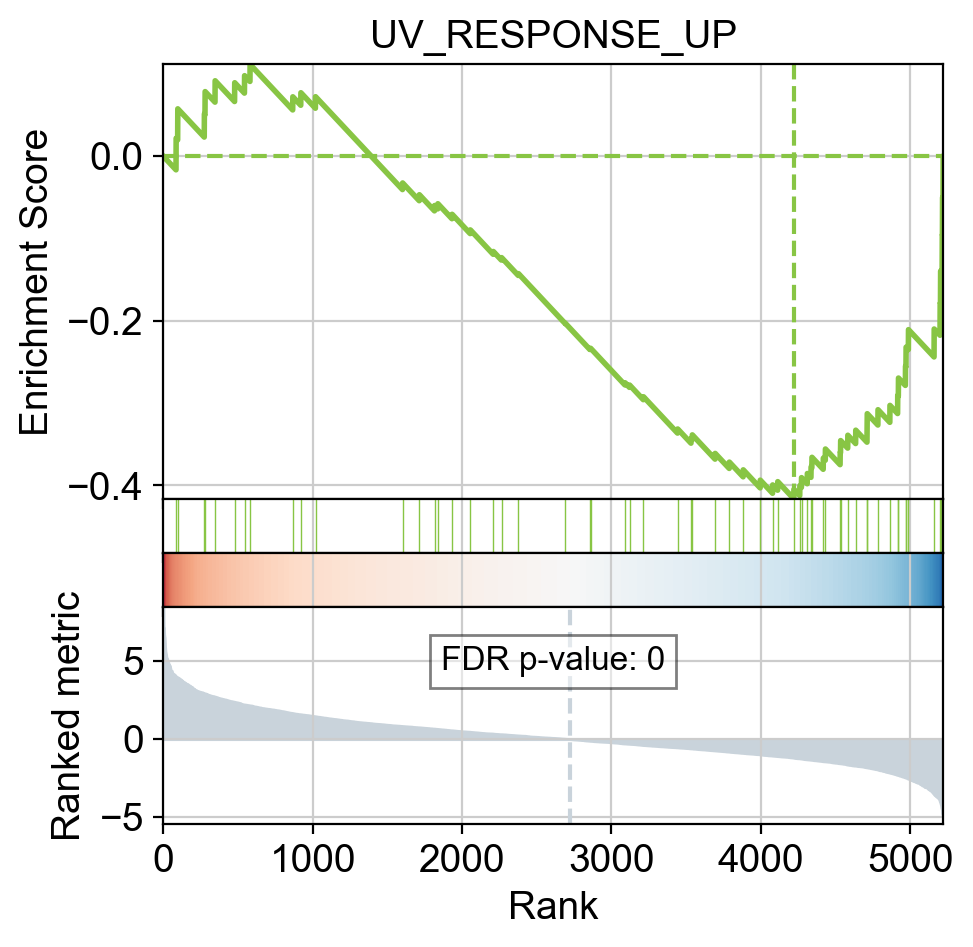

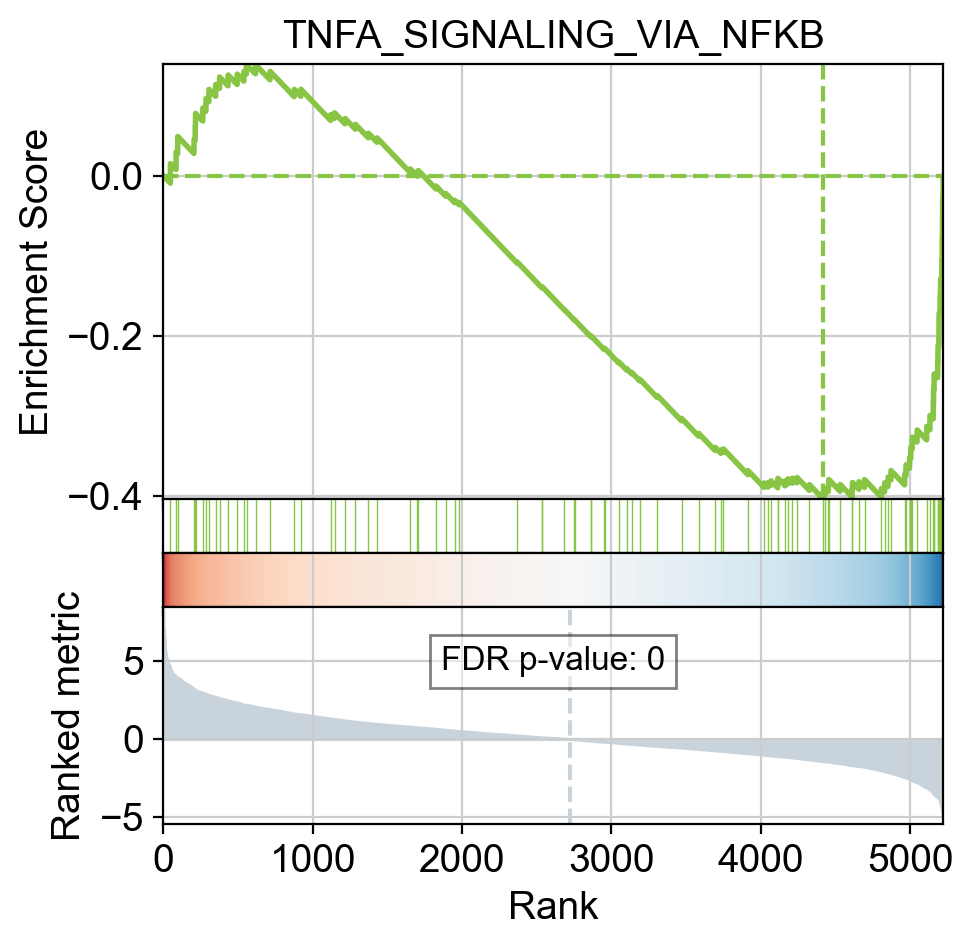

In [45]:
import matplotlib.pyplot as plt

selected_terms = ["UV_RESPONSE_UP", "TNFA_SIGNALING_VIA_NFKB"]


for set_name in selected_terms:
    print(set_name)

    # Extract FDR p-value
    fdr_pval = gsea_hallmark.loc[gsea_hallmark['Term'] == set_name, 'FDR p-value'].values
    if len(fdr_pval) > 0:
        fdr_pval_text = f"FDR p-value: {fdr_pval[0]:.3g}"
    else:
        fdr_pval_text = "FDR p-value: N/A"

    # Create the plot
    fig = dc.plot_running_score(
        df=results_df,
        stat='stat',
        net=msigdb_filtered,
        source='geneset',
        target='genesymbol',
        set_name=set_name,
        return_fig = True
    )

    axes = fig[0].get_axes()
    main_ax = axes[3]

    xlim = main_ax.get_xlim()
    ylim = main_ax.get_ylim()
    x_center = (xlim[0] + xlim[1]) / 2
    y_center = 5

    main_ax.text(x_center, y_center, fdr_pval_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.savefig(f"figures/final/gsea/pseudobulk_mature_neutrophils_AML_vs_HD_{set_name}.pdf")


# PROGENy

In [46]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


In [47]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Mature Neutrophils,1.804955,-2.433639,0.285848,0.689858,-1.557997,0.089823,0.789456,3.121544,0.943115,-2.633894,-0.602987,-0.518335,-0.009391,-2.977033


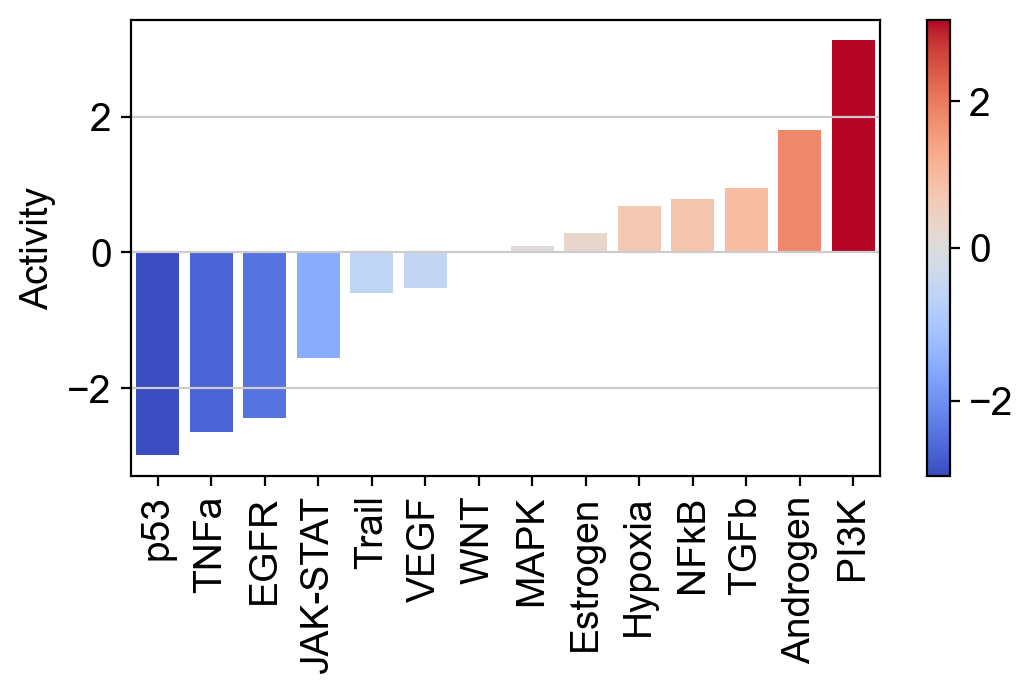

In [48]:
fig = dc.plot_barplot(
    acts=pathway_acts,
    contrast="Mature Neutrophils",
    top=25,
    vertical=False,
    figsize=(6, 3), return_fig=True
)

plt.savefig("figures/final/pathways_activity_score_mature_neutrophils_aml_vs_hd.pdf", transparent = True, bbox_inches="tight")



# CollecTRI

In [54]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;10786671;10914736;11274400;11279234;11287602;114356...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;24550509;24587342;7479881;8683106;8943338;9121484;9...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [55]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,AHR,AIRE,AP1,APEX1,AR,ARID4A,ARNT,ASCL1,ATF1,ATF2,...,ZGLP1,ZIC1,ZNF143,ZNF148,ZNF331,ZNF350,ZNF354C,ZNF362,ZNF699,ZNF91
Mature Neutrophils,-1.459332,-2.325802,-0.604949,-0.584862,2.457101,-0.201589,1.301936,-0.991473,-1.601603,-0.314567,...,0.982279,-0.084914,0.192075,-1.477804,0.757557,-1.518398,-0.238267,-1.367371,-0.07639,-0.950875


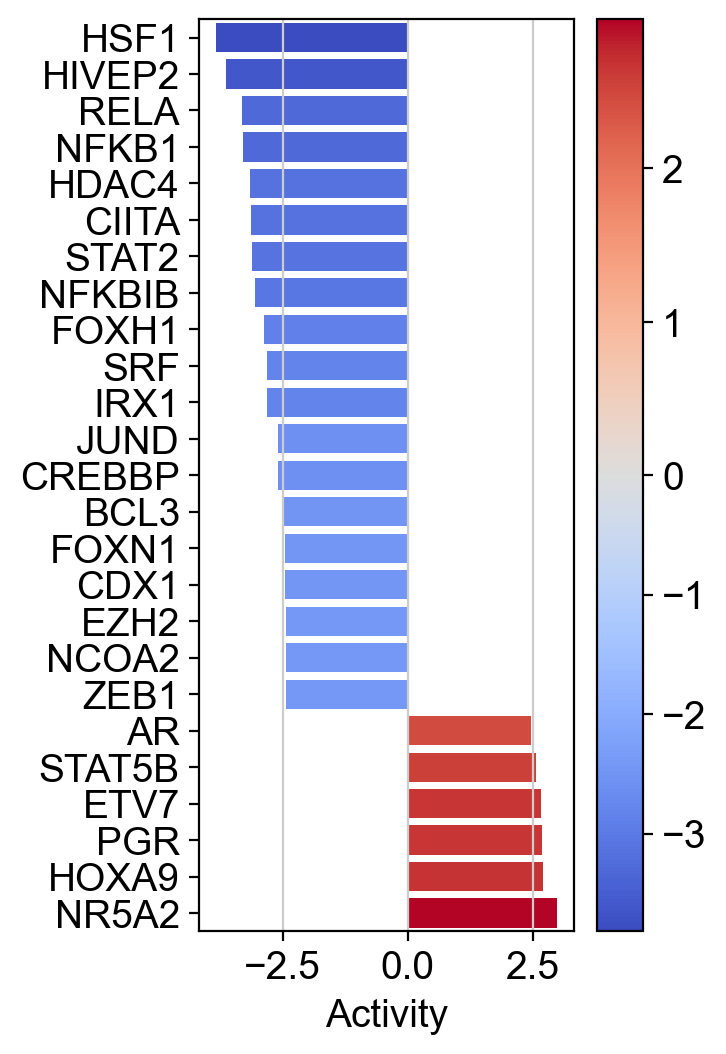

In [56]:
dc.plot_barplot(
    acts=tf_acts,
    contrast="Mature Neutrophils",
    top=25,
    vertical=True,
    figsize=(3, 6)
)

plt.savefig("figures/final/tf/tf_activity_score_mature_neutrophils_aml_vs_hd.pdf", transparent = True, bbox_inches="tight")

